### Sentiment Analysis on YELP dataset

In [5]:
import pandas as pd
# Loading the dataset
file_path = "D:/Masters_docs/Datasets/YELP_Data/Yelp_sub5000.csv"
dataset = pd.read_csv(file_path)
dataset.head()

,stars,text,label
0,5,I've taken a lot of spin classes over the year...,positive
1,5,"Wow! Yummy, different, delicious. Our favo...",positive
2,4,Cute interior and owner (?) gave us tour of up...,positive
3,1,I am a long term frequent customer of this est...,negative
4,5,Loved this tour! I grabbed a groupon and the p...,positive


In [7]:
# Checking for missing values
missing_values = dataset.isnull().sum()

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

In [11]:
# Downloading NLTK data
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hajra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Hajra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hajra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# Initializing
lemmatizer = WordNetLemmatizer()

In [15]:
# Preprocessing function
def preprocess(text):
    # Covert to lowercase
    text = text.lower()
    # Remove special characters, punctuation and numbers
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [17]:
# Apply preprocessing function
dataset['text'] = dataset['text'].astype(str).apply(preprocess)

In [19]:
dataset.head()

,stars,text,label
0,5,"[taken, lot, spin, class, year, nothing, compa...",positive
1,5,"[wow, yummy, different, delicious, favorite, l...",positive
2,4,"[cute, interior, owner, gave, u, tour, upcomin...",positive
3,1,"[long, term, frequent, customer, establishment...",negative
4,5,"[loved, tour, grabbed, groupon, price, great, ...",positive


In [21]:
# Selecting specific columns
preprocessed_yelp = dataset[['label', 'text']]

# Saving to new csv file
preprocessed_yelp.to_csv('D:/Masters_docs/Datasets/YELP_Data/processed_yelp.csv', index=False)

preprocessed_yelp.head()

,label,text
0,positive,"[taken, lot, spin, class, year, nothing, compa..."
1,positive,"[wow, yummy, different, delicious, favorite, l..."
2,positive,"[cute, interior, owner, gave, u, tour, upcomin..."
3,negative,"[long, term, frequent, customer, establishment..."
4,positive,"[loved, tour, grabbed, groupon, price, great, ..."


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [25]:
# Loading the dataset
df = pd.read_csv('D:/Masters_docs/Datasets/YELP_Data/processed_yelp.csv')

In [27]:
# Define features
X = df['text']
y = df['label'].map({'positive': 1, 'negative': 0})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Using Tfidf as vectorizer

In [29]:
# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [31]:
# Train a model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [33]:
# Make predictions
y_pred = model.predict(X_test_tfidf)

In [35]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy:  0.891156462585034

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.52      0.67       188
           1       0.88      0.99      0.93       694

    accuracy                           0.89       882
   macro avg       0.91      0.76      0.80       882
weighted avg       0.90      0.89      0.88       882



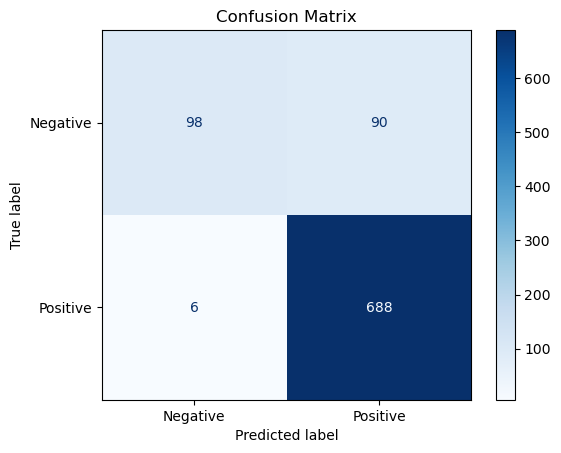

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test and y_pred are already defined
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Using Word2Vec as a vectorizer

In [39]:
from gensim.models import Word2Vec
import numpy as np

# Convert string representations of lists to actual lists
tokenized_texts = df['text'].apply(eval).tolist()

In [41]:
# Train a Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=200, window=15, min_count=2, sg=2, workers=4)

In [43]:
# Function to convert sentence into vectors
def sent_to_vec(sentence, model, vector_size):
    words = [word for word in sentence if word in model.wv]
    if not words:
        return np.zeros(vector_size)
    return np.mean(model.wv[words], axis=0)

In [45]:
# Create sentence vectors
sent_vectors = np.array([sent_to_vec(sentence, w2v_model, 200)for sentence in tokenized_texts])

# Update dataframe with newly created vectors
sent_vectors_df = pd.DataFrame(sent_vectors)
sent_vectors_df['label'] = df['label'].map({'positive': 1, 'negative': 0})

In [47]:
# Define features
X = sent_vectors_df.iloc[:, :-1].values
y = sent_vectors_df['label'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
# Train a model
model = LogisticRegression(max_iter = 1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [51]:
# Make predictions
y_pred = model.predict(X_test)

In [53]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy:  0.9024943310657596

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.66      0.74       188
           1       0.91      0.97      0.94       694

    accuracy                           0.90       882
   macro avg       0.88      0.81      0.84       882
weighted avg       0.90      0.90      0.90       882



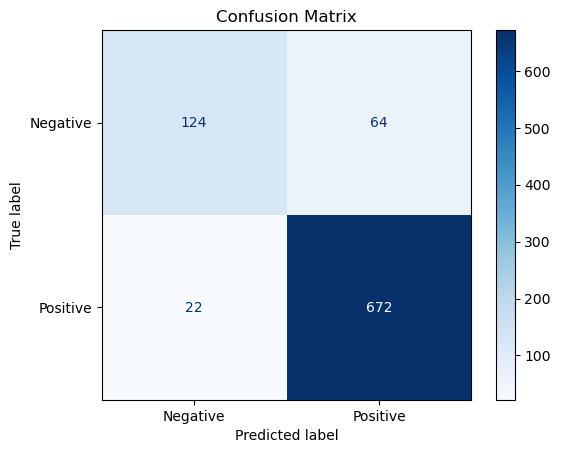

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test and y_pred are already defined
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Using DistilBERT

In [57]:
!pip install torch transformers datasets scikit-learn


In [59]:
pip install accelerate>=0.26.0

Note: you may need to restart the kernel to use updated packages.


import pandas as pd
from sklearn.model_selection import train_test_split

In [61]:
# Loading the dataset
df = pd.read_csv('D:/Masters_docs/Datasets/YELP_Data/processed_yelp.csv')
df.head()

,label,text
0,positive,"['taken', 'lot', 'spin', 'class', 'year', 'not..."
1,positive,"['wow', 'yummy', 'different', 'delicious', 'fa..."
2,positive,"['cute', 'interior', 'owner', 'gave', 'u', 'to..."
3,negative,"['long', 'term', 'frequent', 'customer', 'esta..."
4,positive,"['loved', 'tour', 'grabbed', 'groupon', 'price..."


In [63]:
# Define features
X = list(df['text'])
y = list(df['label'].map({'positive': 1, 'negative': 0}))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [65]:
# Tokenizing using DistilBert tokenizer
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [67]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [69]:
from torch.utils.data import Dataset, DataLoader
import torch

# Custom Dataset Class
class EncodedDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get input features for the given index
        item = {key: val[idx] for key, val in self.encodings.items()}
        # Add the label
        item['labels'] = self.labels[idx]
        return item

# Convert to Dataset objects
train_dataset = EncodedDataset(train_encodings, y_train)
test_dataset = EncodedDataset(test_encodings, y_test)

In [71]:
# Loading a pretrained DistilBert model
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="D:/Masters_docs/Datasets/YELP_Data/results",
    learning_rate=2e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="D:/Masters_docs/Datasets/YELP_Data/logs",
    logging_steps=10,
)
    

In [73]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()                                 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.700700
20,0.678800
30,0.667200
40,0.636000
50,0.626100
60,0.544000
70,0.536000
80,0.527500
90,0.445400
100,0.365000


TrainOutput(global_step=882, training_loss=0.3159390402759284, metrics={'train_runtime': 3771.6812, 'train_samples_per_second': 1.869, 'train_steps_per_second': 0.234, 'total_flos': 933895160524800.0, 'train_loss': 0.3159390402759284, 'epoch': 2.0})

In [77]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation results:", results)


Evaluation results: {'eval_loss': 0.24493025243282318, 'eval_runtime': 133.1916, 'eval_samples_per_second': 6.622, 'eval_steps_per_second': 0.42, 'epoch': 2.0}


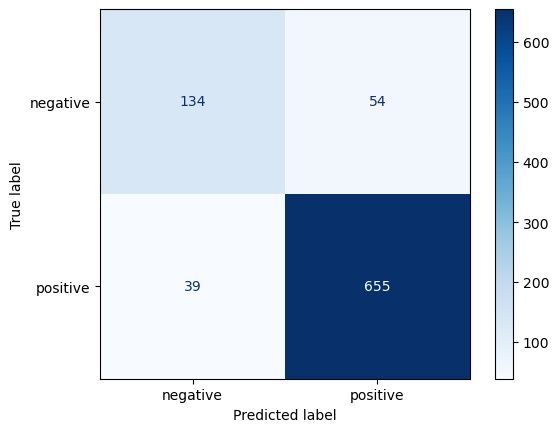

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = []
for text in X_test:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)
    y_pred.append(predictions.item())

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot(cmap="Blues")


In [81]:
# Get predictions
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
y_pred = torch.argmax(torch.tensor(logits), axis=1)
y_true = predictions.label_ids


In [83]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.935374149659864


SHAP XAI

In [111]:
from transformers import pipeline
import shap

In [131]:
#Create Huggingface pipeline
pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, return_all_scores=True)

#SHAP explainer
explainer = shap.Explainer(pipe)

#Prediction explanation
shap_values = explainer(["The food was good, but the service was worst."])

#Visualization
shap.plots.text(shap_values)


Device set to use cpu
C:\Users\Hajra\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


negative = 0 ; positive = 1

INTEGRATED GRADIENTS

In [143]:
pip install transformers_interpret

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 12.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/793.8 kB ? eta -:--:--
   ---------------------------------------- 793.8/793.8 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 8.27.0
    Uninstalling ipython-8.27.0:
      Successfully uninstalled ipython-8.27.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.5.1 requires ipython!=8.17.1,<9.0.0,>=8.13.0; python_version > "3.8", but you have ipython 7.34.0 which is incompatible.
spyder-kernels 2.5.0 requires ipython!=8.17.1,<9,>=8.13.0; python_version > "3.8", but you have ipython 7.34.0 which is incompatible.


In [147]:
from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

In [165]:
word_attributions = cls_explainer("The food was amazing and the service was good.")

In [167]:
cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.82),LABEL_1,2.09,[CLS] the food was amazing and the service was good . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.82),LABEL_1,2.09,[CLS] the food was amazing and the service was good . [SEP]


negative = 0 ; positive = 1